# Fiddler Guardrails Free Trial Quick Start Guide

Fiddler Guardrails provides enterprise-grade protection against critical LLM risks in production environments. This solution actively moderates and mitigates harmful content in both prompts and responses, including hallucinations, toxicity ,safety violations, prompt injection attacks, and jailbreaking attempts. The solution is powered by proprietary, fine-tuned, task-specific Fiddler Trust Models, specifically engineered for real-time content analysis.


## Free Trial Offer
* [Sign Up for an API Key](https://docs.fiddler.ai/tutorials-and-quick-starts/fiddler-guardrails-free-trial/guardrails-quick-start-guide) (needed to run this notebook)
* [Free Trial Documentation](https://docs.fiddler.ai/technical-reference/fiddler-guardrails-free-trial-documentation)
* [Guardrails FAQ](https://docs.fiddler.ai/tutorials-and-quick-starts/fiddler-guardrails-free-trial/guardrails-faq)

---

## Faithfulness Model

This Fiddler Trust Model detects hallucinations by evaluating the accuracy and reliability of facts presented in AI-generated text responses in retrieval-augmented generation (RAG) contexts.

The model requires two inputs:
1. Response: the text generated by your generative application
1. Context Documents: the reference text that the application response must remain faithful to

The output is a single score (float) representing the factual consistency between the response and the provided context.

---

## Notebook Summary

In this notebook we load a subset of RAGTruth Q&A tasks, a hallucination corpus within a RAG setting. We send these examples to the FTL Response Faithfulness Guardrail. We report on classification metrics and latency.

This notebook should complete within 1 minute.

In [ ]:
%pip install -q matplotlib numpy pandas requests scikit-learn

import time
from typing import Tuple


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
)


In [2]:
plt.style.use("ggplot")
pd.set_option("display.max_colwidth", None)


In [ ]:
FIDDLER_GUARDRAILS_TOKEN = ""

GUARDRAILS_BASE_URL = "https://guardrails.cloud.fiddler.ai/v3/guardrails"

FAITHFULNESS_GUARDRAILS_URL = f"{GUARDRAILS_BASE_URL}/ftl-response-faithfulness"

GUARDRAILS_HEADERS = {
    "Authorization": f"Bearer {FIDDLER_GUARDRAILS_TOKEN}",
    "Content-Type": "application/json",
}

assert FIDDLER_GUARDRAILS_TOKEN != "", (
    "Set :FIDDLER_GUARDRAILS_TOKEN above; sign-up at https://docs.fiddler.ai/tutorials-and-quick-starts/fiddler-guardrails-free-trial/guardrails-quick-start-guide"
)

## 1. Load RAGTruth QA Dataset

### 1.1 Download and Sample

Download from GitHub and set columns we'll use for looking at performance

In [4]:
def read_ragtruth_qa_from_github(sample_size: int = None) -> pd.DataFrame:
    """Read RAGTruth from GitHub and filter to the Q&A examples in the test set.

    Args:
        sample_size (int, optional): How many records to return. If specified then a balanced sample will returned.
            Defaults to None, which means all records will be returned

    Returns:
        pd.DataFrame: RAGTruth dataset filtered to Q&A examples in the test set, optionally downsampled.
    """
    ragtruth_source_info = pd.read_json(
        "https://github.com/ParticleMedia/RAGTruth/raw/refs/heads/main/dataset/source_info.jsonl",
        lines=True,
    )
    ragtruth_response = pd.read_json(
        "https://github.com/ParticleMedia/RAGTruth/raw/refs/heads/main/dataset/response.jsonl",
        lines=True,
    )
    df = pd.merge(
        ragtruth_source_info,
        ragtruth_response,
        left_on="source_id",
        right_on="source_id",
    )
    df_qa = df[
        (df["task_type"] == "QA") & (df["split"] == "test") & (df["quality"] == "good")
    ]

    if sample_size is None:
        return df_qa
    else:
        df_qa_pos = df_qa[df_qa["labels"].apply(len) == 0].sample(
            sample_size // 2, random_state=19
        )
        df_qa_neg = df_qa[df_qa["labels"].apply(len) != 0].sample(
            sample_size // 2, random_state=19
        )
        return pd.concat([df_qa_pos, df_qa_neg])


In [5]:
ragtruth_qa = read_ragtruth_qa_from_github(
    sample_size=20
)  # Note: the Free Trial is limited to 70 requests in 1 hour

##

### 1.2 Preview the Data

In [6]:
ragtruth_qa["n_input_words"] = (
    ragtruth_qa["source_info"].astype(str).str.split().str.len()
    + ragtruth_qa["response"].astype(str).str.split().str.len()
)  # a rough estimate of word count

ragtruth_qa["is_faithful"] = (ragtruth_qa["labels"].apply(len) == 0).astype(int)
display(ragtruth_qa["is_faithful"].value_counts())

is_faithful
1    10
0    10
Name: count, dtype: int64

In [7]:
display(
    ragtruth_qa[["is_faithful", "source_info", "response"]]
    .sample(frac=1, random_state=19)
    .head(4)
)

,is_faithful,source_info,response
16358,1,"{'question': 'where does 1099-patr go on 1040', 'passages': 'passage 1:Audit Assistant. Get the information you need. Form 1099-PATR (Taxable Distributions Received From Cooperatives). Per the IRS instructions, patronage dividends and other distributions in boxes 1,2,3, and 5 from a cooperative are reported on Schedule C, Schedule F, or Form 4835. passage 2:Get the information you need. Form 1099-PATR (Taxable Distributions Received From Cooperatives). Per the IRS instructions, patronage dividends and other distributions in boxes 1,2,3, and 5 from a cooperative are reported on Schedule C, Schedule F, or Form 4835. passage 3:Copy A appears in red, similar to the official IRS form. Do not file copy A downloaded from this website. The official printed version of this IRS form is scannable, but the online version of it, printed from this website, is not. '}","Based on the given passages, it is clear that the 1099-PATR tax form is used to report patronage dividends and other distributions received from cooperatives. However, the specific location where this form goes on a 1040 tax return is not explicitly mentioned. It would be best to refer to the instructions on the 1040 tax return form itself for guidance on how to properly include the 1099-PATR."
12458,0,"{'question': 'typical weather in indiana', 'passages': 'passage 1:When, how much and how often Indianapolis, Indiana has snow — with monthly and yearly averages for total days and inches of snowfall, snow accumulation, heavy snowstorms and first snowfall. Snowfall and snow accumulation averages for: Fort Wayne Gary & Michigan City South Bend. Hot, Humid Weather in Indiana passage 2:Average Weather in Indianapolis Indiana, United States. In Indianapolis, the summers are long, warm, humid, and wet; the winters are chilly and windy; and it is partly cloudy year round. Over the course of the year, the temperature typically varies from 22°F to 85°F and is rarely below 3°F or above 92°F. passage 3:Wettest year was recorded in 1876 at Indianapolis : 57.65 inches of measured rain. 1 Driest year was recorded in 1934 at Indianapolis : 24.97 inches of measured rain. 2 Most snow fall recorded in 1979 in Rockford : 74.5 inches in one season. 3 Maximum monthly precipitation: over 16 inches in July 2003 and 2004 at Kokomo . '}","Typical weather in Indiana:\n\nIndianapolis, Indiana experiences a hot, humid climate with long, warm summers and chilly, windy winters. The temperature ranges from 22°F to 85°F throughout the year, with an average annual temperature of 61°F. Precipitation is also common in Indiana, with the wettest year recorded in 1876 at Indianapolis, measuring 57.65 inches of rain. However, the driest year was recorded in 1934, with only 24.97 inches of rain."
13376,0,"{'question': 'how to peel potatoes fast', 'passages': 'passage 1:Place washed whole, unpeeled potatoes into a pot and cover with cold water. The “shocking” process of going from the hot boiling water to the cold ice water helps release the skin from the flesh and makes the potato quite easy to peel. passage 2:True the skin comes off fairly easy but it takes so freakin long! Especially if you are peeling a crap load of potatoes. Here is the easiest way (or at least the easiest way I’ve discovered) to peel a cooked potato. Step 1.) Bring a pot of water to a boil. Step 2.) With a knife, score your potatoes all the way around the center. Step 3.) Place your potatoes in the pot and boil for about 15 minutes or so. Step 4.) Prepare a bowl of ice water and place your potatoes in the water. Step 5.) Swish it around for a few seconds just enough so that it’s cool enough to handle. Step 6.) Remove your potatoe from the water and remove the skin. passage 3:You will need. Step 1 Cut the potato skin Make a cut all around the potato, lengthwise. Try to slice only the skin, not the actual potato. Step 2 Boil it Put the potato in a pot of boiling water. Step 3 Cool it off Plunge the potat

## 2. Helper Code for Guardrails and Evaluation Code


In [8]:
def get_faithfulness_response(
    context: str, response: str, sleep_seconds: float = 0.350
) -> Tuple[float, float]:
    """Invoke the guardrail for Faithfulness, returning the faithfulness score and latency time

    Args:
        context (str): Guardrails context field
        response (str): Guardrails response field

    Returns:
        Tuple[float, float]: Faithfulness score and latency in seconds.
    """
    time.sleep(sleep_seconds)
    data = {
        "context": context,
        "response": response,
    }
    try:
        response = requests.post(
            FAITHFULNESS_GUARDRAILS_URL,
            headers=GUARDRAILS_HEADERS,
            json={"data": data},
            timeout=30,
        )
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None, response.elapsed.total_seconds()

    return response.json()["fdl_faithful_score"], response.elapsed.total_seconds()

In [9]:
faithful_display_name_map = {0: "hallucination", 1: "faithful"}
pos_label = "faithful"

In [10]:
def plot_classification_results(df: pd.DataFrame, ds_name: str):
    global faithful_display_name_map, pos_label

    df_clean = df.dropna(subset=["fdl_faithful_score"])
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(ds_name)
    pr = PrecisionRecallDisplay.from_predictions(
        df_clean["is_faithful"].map(faithful_display_name_map),
        y_pred=df_clean["fdl_faithful_score"],
        ax=axes[2],
        pos_label=pos_label,
    )
    pr.ax_.set_title(f"Precision-Recall Curve")

    roc = RocCurveDisplay.from_predictions(
        df_clean["is_faithful"].map(faithful_display_name_map),
        y_pred=df_clean["fdl_faithful_score"],
        ax=axes[1],
        plot_chance_level=True,
        pos_label=pos_label,
    )
    roc.ax_.set_title(f"ROC Curve")

    axes[0].hist(
        df_clean[df_clean["is_faithful"] == 1]["fdl_faithful_score"],
        color="cornflowerblue",
        label="Faithful",
        bins=np.arange(0, 1.05, 0.1),
    )
    axes[0].hist(
        df_clean[df_clean["is_faithful"] == 0]["fdl_faithful_score"],
        color="orange",
        label="Hallucination",
        histtype="step",
        linewidth=1.5,
        bins=np.arange(0, 1.05, 0.1),
    )
    axes[0].set_xlabel("Score")
    axes[0].set_ylabel("Frequency", axes=axes[0])
    axes[0].set_title(f"Faithfulness Scores")
    axes[0].legend()
    return fig

In [11]:
def plot_latency(df: pd.DataFrame, ds_name: str):
    df_clean = df.dropna(subset=["fdl_faithful_score"])
    p95_latency = int(1000 * df_clean["fdl_faithful_latency"].quantile(0.95).round(3))
    p50_words_per_sec = int(
        (df_clean["n_input_words"] / df_clean["fdl_faithful_latency"]).median()
    )

    fig, ax = plt.subplots()
    fig.suptitle(f"{ds_name} Latency")

    ax.hist(df_clean["fdl_faithful_latency"])
    ax.set_title(f"p95={p95_latency}ms; median {p50_words_per_sec} words per second")
    ax.set_xlabel("Seconds")
    ax.set_ylabel("Frequency")

    return fig

## 3. Run Dataset Through Guardrails

We will sleep between requests to avoid rate-limit restrictions on the free trial.

In [12]:
ragtruth_qa[["fdl_faithful_score", "fdl_faithful_latency"]] = ragtruth_qa.apply(
    lambda row: get_faithfulness_response(str(row["source_info"]), row["response"]),
    axis=1,
    result_type="expand",
)

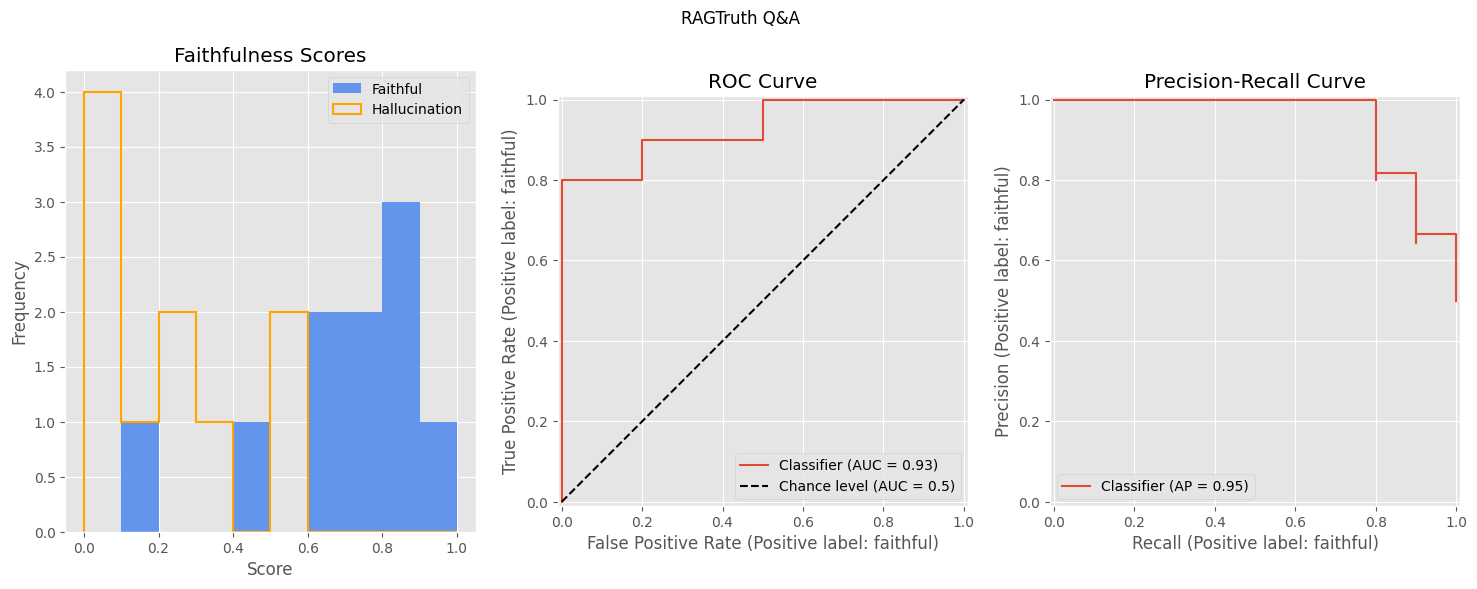

In [13]:
plt.show(plot_classification_results(ragtruth_qa, "RAGTruth Q&A"))

In [14]:
print(
    classification_report(
        ragtruth_qa["is_faithful"].map(faithful_display_name_map),
        (ragtruth_qa["fdl_faithful_score"] > 0.6)
        # This is a good default threshold but you can change to match your use-case
        .astype(int)
        .map(faithful_display_name_map),
    )
)

               precision    recall  f1-score   support

     faithful       1.00      0.80      0.89        10
hallucination       0.83      1.00      0.91        10

     accuracy                           0.90        20
    macro avg       0.92      0.90      0.90        20
 weighted avg       0.92      0.90      0.90        20



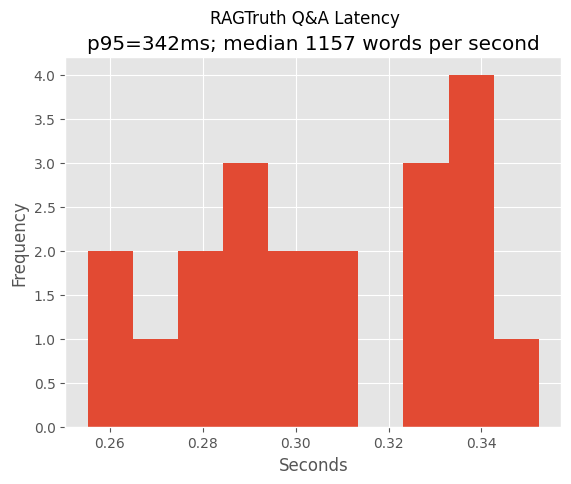

In [15]:
rag_latency_fig = plot_latency(ragtruth_qa, "RAGTruth Q&A")
plt.show()